# Выбор локации для скважины

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построем модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from scipy import stats

RANDOM = 42
state = RandomState(RANDOM) 

Запишем данные нужные для расчета прибыли

In [2]:
BUDGET = 10**10
LOSSES = 2.5
INCOME_MATERIALS = 450
INCOME_PRODUCT = 450000
NUMBER_WELLS = 200

In [3]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
display(data_0.head())
data_0.info()
data_0.describe()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [5]:
display(data_1.head())
data_1.info()
data_1.describe()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [6]:
display(data_2.head())
data_2.info()
data_2.describe()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [7]:
print(data_0.duplicated().sum())
print(data_1.duplicated().sum())
print(data_2.duplicated().sum())

0
0
0


In [8]:
display(data_0.corr)
display(data_1.corr)
display(data_2.corr)

<bound method DataFrame.corr of           id        f0        f1        f2     product
0      txEyH  0.705745 -0.497823  1.221170  105.280062
1      2acmU  1.334711 -0.340164  4.365080   73.037750
2      409Wp  1.022732  0.151990  1.419926   85.265647
3      iJLyR -0.032172  0.139033  2.978566  168.620776
4      Xdl7t  1.988431  0.155413  4.751769  154.036647
...      ...       ...       ...       ...         ...
99995  DLsed  0.971957  0.370953  6.075346  110.744026
99996  QKivN  1.392429 -0.382606  1.273912  122.346843
99997  3rnvd  1.029585  0.018787 -1.348308   64.375443
99998  7kl59  0.998163 -0.528582  1.583869   74.040764
99999  1CWhH  1.764754 -0.266417  5.722849  149.633246

[100000 rows x 5 columns]>

<bound method DataFrame.corr of           id         f0         f1        f2     product
0      kBEdx -15.001348  -8.276000 -0.005876    3.179103
1      62mP7  14.272088  -3.475083  0.999183   26.953261
2      vyE1P   6.263187  -5.948386  5.001160  134.766305
3      KcrkZ -13.081196 -11.506057  4.999415  137.945408
4      AHL4O  12.702195  -8.147433  5.004363  134.766305
...      ...        ...        ...       ...         ...
99995  QywKC   9.535637  -6.878139  1.998296   53.906522
99996  ptvty -10.160631 -12.558096  5.005581  137.945408
99997  09gWa  -7.378891  -3.084104  4.998651  137.945408
99998  rqwUm   0.665714  -6.152593  1.000146   30.132364
99999  relB0  -3.426139  -7.794274 -0.003299    3.179103

[100000 rows x 5 columns]>

<bound method DataFrame.corr of           id        f0        f1        f2     product
0      fwXo0 -1.146987  0.963328 -0.828965   27.758673
1      WJtFt  0.262778  0.269839 -2.530187   56.069697
2      ovLUW  0.194587  0.289035 -5.586433   62.871910
3      q6cA6  2.236060 -0.553760  0.930038  114.572842
4      WPMUX -0.515993  1.716266  5.899011  149.600746
...      ...       ...       ...       ...         ...
99995  4GxBu -1.777037  1.125220  6.263374  172.327046
99996  YKFjq -1.261523 -0.894828  2.524545  138.748846
99997  tKPY3 -1.199934 -2.957637  5.219411  157.080080
99998  nmxp2 -2.419896  2.417221 -5.548444   51.795253
99999  V9kWn -2.551421 -2.025625  6.090891  102.775767

[100000 rows x 5 columns]>

## Обучение и проверка модели

In [9]:
features_0 = data_0.drop(['product', 'id'], axis=1)  # извлекаем признаки 
target_0 = data_0['product'] # извлекаем целевой признак

features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=12345)

In [10]:
features_1 = data_1.drop(['product', 'id'], axis=1)  # извлекаем признаки 
target_1 = data_1['product'] # извлекаем целевой признак

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)

In [11]:
features_2 = data_2.drop(['product', 'id'], axis=1)  # извлекаем признаки 
target_2 = data_2['product'] # извлекаем целевой признак

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345)

In [12]:
# Обучим модель, для удобства создадим массив с тренировочными и валидными наборами
train_features_general = [features_train_0, features_train_1, features_train_2]
train_targets_general = [target_train_0, target_train_1, target_train_2]

valid_features_general = [features_valid_0, features_valid_1, features_valid_2]
valid_targets_general = [target_valid_0, target_valid_1, target_valid_2]

predictions_general = []

for num_geo in range(len(train_features_general)):
    model = LinearRegression()
    model.fit(train_features_general[num_geo], train_targets_general[num_geo])
    predictions = model.predict(valid_features_general[num_geo])
    predictions_general.append(pd.Series(predictions))
    print('RMSE для региона №' + str(num_geo + 0), mean_squared_error(valid_targets_general[num_geo], predictions) ** 0.5)
    print('Cредний запас предсказанного сырья для региона', predictions.mean(), '\n')

RMSE для региона №0 37.5794217150813
Cредний запас предсказанного сырья для региона 92.59256778438035 

RMSE для региона №1 0.893099286775617
Cредний запас предсказанного сырья для региона 68.728546895446 

RMSE для региона №2 40.02970873393434
Cредний запас предсказанного сырья для региона 94.96504596800489 



# Вывод: 
Нулевой регион: по среднему объему запасов региона на втором месте

Первый регион: Ошибка в первом регионе самая маленькая, средний запас проигрывает другим регионам

Второй регион: Самый большой средний объем запасов

По полученным данным мы определили, что в нулевом и втором регионе наша модель предсказывает значения хуже чем в первом. Но самый большой запас сырья по предсказаниям находится в третьем регионе.       

## Подготовка к расчёту прибыли

In [13]:
# Достаточное количество добычи нефти, для безубыточности
PRODUCT = BUDGET / INCOME_PRODUCT / NUMBER_WELLS

print(PRODUCT)

111.11111111111111


Вывод: скважина должна получать минимум 111 баррелей, таких скважин нет, все производят меньше.

## Расчёт прибыли и рисков 

In [14]:
def profit(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count].sum()
    price = selected * INCOME_PRODUCT
    return (price - BUDGET) / 10 ** 9

for i in range(3):
    print('Прибыль региона №' +  str(i + 0), profit(valid_targets_general[i].reset_index(drop=True), predictions_general[i], 200))

Прибыль региона №0 3.3208260431398506
Прибыль региона №1 2.4150866966815108
Прибыль региона №2 2.7103499635998327


95%-й доверительный интервал: (-0.10209009483793655 : 0.9479763533583688)
Средняя прибыль: 0.42593852691059236
Риск убытка: 6.0


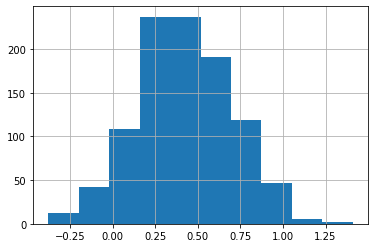

95%-й доверительный интервал: (0.12812323143308443 : 0.9536129820669085)
Средняя прибыль: 0.5182594936973248
Риск убытка: 0.3


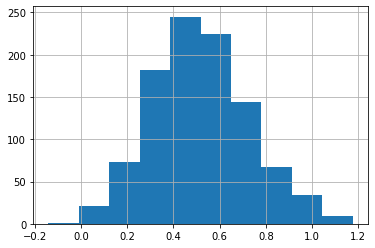

95%-й доверительный интервал: (-0.11585260916001143 : 0.9896299398445739)
Средняя прибыль: 0.4201940053440501
Риск убытка: 6.2


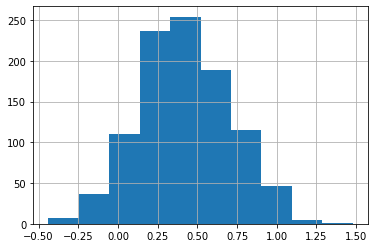

In [15]:
# Bootstrap
values = [[],[],[]]
state = np.random.RandomState(12345)

for i in range(3):
    for j in range(1000):
        target_sample = valid_targets_general[i].reset_index(drop=True).sample(n = 500, replace = True, random_state=state)
        probs_subsample = predictions_general[i].reset_index(drop=True)[target_sample.index]
        
        values[i].append(profit(target_sample.reset_index(drop = True), probs_subsample.reset_index(drop = True), 200))
        
    values[i] = pd.Series(values[i])
    values[i].hist()
    print('95%-й доверительный интервал: (' + str(values[i].quantile(0.025)) + ' : ' + str(values[i].quantile(0.975)) + ')')
    print('Средняя прибыль:', values[i].mean())
    print('Риск убытка:', (values[i] < 0).mean()*100)
    plt.show()

# Вывод:
По полученным данным можно сделать вывод, что третий регион больше подходит:

Доверительный интервал: (0.12812323143308443 : 0.9536129820669085)
Средняя прибыль в первом регионе: 0.5182594936973248
Риски: 0.3 %